In [1]:
import random
from tools import utils
from PIL import Image
from tqdm import tqdm
import torch

In [2]:
class Arguments:
    def __init__(self):
        self.data_root = 'data/maplm_v0.1'
        self.output_dir = 'runs'
        self.test_split = 'train'
        self.test_number = 100
        self.exp_label = 'transformer'
        self.random_seed = 42
        self.debug = False

arguments = Arguments()
random.seed(arguments.random_seed)
frames, frame_ids = utils.load_data(arguments)
result_file_name = utils.get_result_file(arguments)

Number of test frames: 100



In [3]:
labels = [
    "Normal city road.",
    "Construction road.",
    "Undeveloped road.",
    "Road mark repainting.",
    "Roundabout.",
    "None of the above."
]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

In [4]:
class MAPLMDataset(torch.utils.data.Dataset):
    """MAPLM dataset."""

    def __init__(self, frames, frame_ids, processor):
        self.frames = frames
        self.frame_ids = frame_ids
        self.processor = processor

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        # get image + text
        frame_id = self.frame_ids[idx]
        frame = self.frames[frame_id]
        questions = frame['qa']
        image_list = frame['image']
        image_path = f'{arguments.data_root}/train/{frame_id}/{image_list[1]}'
        image = Image.open(image_path)
        text = questions[0]['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        choices = questions[0]['choices']
        labels = [label2id[choice] for choice in choices]
        scores = [1 if label == questions[0]['answer'] else 0.1 for label in labels]
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [5]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = MAPLMDataset(frames = frames,
                       frame_ids=frame_ids,
                     processor=processor)

In [6]:
dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [7]:
processor.decode(dataset[0]['input_ids'])

'[CLS] what kind of road scene is it in the images? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [8]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

In [9]:
[id2label[label] for label in labels]

['Normal city road.',
 'Construction road.',
 'Undeveloped road.',
 'Road mark repainting.',
 'Roundabout.',
 'None of the above.']

In [10]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=id2label,
                                                 label2id=label2id)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

Let's verify a batch:

In [12]:
batch = next(iter(train_dataloader))

In [13]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 512, 384])
pixel_mask torch.Size([4, 512, 384])
labels torch.Size([4, 6])


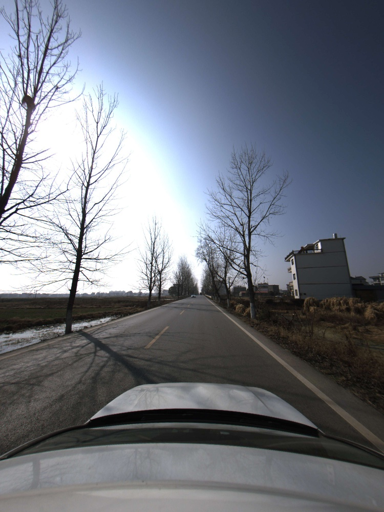

In [14]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [15]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] what kind of road scene is it in the images? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [16]:
labels = torch.nonzero(batch['labels'][batch_idx]).squeeze().tolist()

In [17]:
[id2label[label] for label in labels]

['Normal city road.',
 'Construction road.',
 'Undeveloped road.',
 'Road mark repainting.',
 'Roundabout.',
 'None of the above.']

## Train a model

Finally, let's train a model! Note that I haven't done any hyperparameter tuning as this notebook was just created for demo purposes. I'd recommend going over the [ViLT paper](https://arxiv.org/abs/2102.03334) for better training settings.

I just wanted to illustrate that you can make the model overfit this dataset.

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(1):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 1.782301425933838


  8%|▊         | 2/25 [00:00<00:05,  4.09it/s]

Loss: 1.652795433998108


 12%|█▏        | 3/25 [00:00<00:05,  3.86it/s]

Loss: 1.6389656066894531


 16%|█▌        | 4/25 [00:01<00:05,  3.73it/s]

Loss: 1.632927417755127


 20%|██        | 5/25 [00:01<00:05,  3.66it/s]

Loss: 1.6364797353744507


 24%|██▍       | 6/25 [00:01<00:05,  3.62it/s]

Loss: 1.6360620260238647


 28%|██▊       | 7/25 [00:01<00:05,  3.59it/s]

Loss: 1.631779670715332


 32%|███▏      | 8/25 [00:02<00:04,  3.55it/s]

Loss: 1.630780577659607


 36%|███▌      | 9/25 [00:02<00:04,  3.55it/s]

Loss: 1.6292273998260498


 40%|████      | 10/25 [00:02<00:04,  3.54it/s]

Loss: 1.630569577217102


 44%|████▍     | 11/25 [00:03<00:03,  3.54it/s]

Loss: 3.5863447189331055


 48%|████▊     | 12/25 [00:03<00:03,  3.53it/s]

Loss: 3.5089223384857178


 52%|█████▏    | 13/25 [00:03<00:03,  3.54it/s]

Loss: 1.646442174911499


 56%|█████▌    | 14/25 [00:03<00:03,  3.53it/s]

Loss: 3.168755531311035


 60%|██████    | 15/25 [00:04<00:02,  3.52it/s]

Loss: 3.0556297302246094


 64%|██████▍   | 16/25 [00:04<00:02,  3.53it/s]

Loss: 4.001504898071289


 68%|██████▊   | 17/25 [00:04<00:02,  3.54it/s]

Loss: 1.8008719682693481


 72%|███████▏  | 18/25 [00:05<00:01,  3.54it/s]

Loss: 2.6421713829040527


 76%|███████▌  | 19/25 [00:05<00:01,  3.54it/s]

Loss: 1.8866534233093262


 80%|████████  | 20/25 [00:05<00:01,  3.54it/s]

Loss: 1.9106130599975586


 84%|████████▍ | 21/25 [00:05<00:01,  3.54it/s]

Loss: 1.9067802429199219


 88%|████████▊ | 22/25 [00:06<00:00,  3.54it/s]

Loss: 1.8968043327331543


 92%|█████████▏| 23/25 [00:06<00:00,  3.54it/s]

Loss: 1.8656055927276611


 96%|█████████▌| 24/25 [00:06<00:00,  3.54it/s]

Loss: 1.832744836807251


100%|██████████| 25/25 [00:06<00:00,  3.58it/s]

Loss: 1.7975471019744873


## Inference

Let's verify whether the model has actually learned something:

In [20]:
example = dataset[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [21]:
processor.decode(example['input_ids'])

'[CLS] what kind of road scene is it in the images? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [22]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [23]:
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)

probs, classes = torch.topk(predicted_classes, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
  print(prob, id2label[class_idx])

0.884266197681427 Normal city road.
0.11336862295866013 Undeveloped road.
0.08858826756477356 None of the above.
0.07700320333242416 Roundabout.
0.07228105515241623 Construction road.
